In [504]:
# %load_ext rpy2.ipython
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster
from sklearn import decomposition, mixture
from scipy.stats import ttest_ind
from clustergram import Clustergram
from sklearn.model_selection import train_test_split
import warnings
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import decomposition
import numpy.linalg as la
warnings.filterwarnings('ignore')
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)

# Part 1

## Data Pre-processing

Reading in files.

In [505]:
control = pd.read_csv('Control_Data.csv') 
exposed = pd.read_csv('Exposed_Data.csv')
data_dictionary = pd.read_csv('data_dictionary.csv')

In [506]:
exposed['exposed'] = 1
control['exposed'] = 0
df = pd.concat([exposed, control], ignore_index = True)
df['urbanicity'] = df['urbanicity'].replace({'S': 'Suburban',
                                             'U': 'Urban',
                                             'R': 'Rural'})

Data cleaning

In [507]:
cat = df.columns[df.dtypes=='object']
df = pd.get_dummies(df, columns=cat) # change categorical into dummy variables
factors = ['zip11', 'cbsa_code', 'census_tract', 'census_block_id', 'census_block_group', 'msa'] #Removing redundant features-- these are all correlated with each other.
df = df.drop(columns = factors) 
df = df.drop(columns=['gender_U']) 

In [508]:
df.dropna(axis='columns', thresh= 1600) #drop columns with too many NA
# Find the fill rate of each Individual blu ID (row)
df['Fill_Rate'] = df.sum(axis = 1) / df.shape[1]
indexNames_low_fill_ind = df[df['Fill_Rate'] < .70].index
# Deleting Individuals (rows) from data frame with low fill rates.
df.drop(indexNames_low_fill_ind, inplace=True)
#fill missing values
df.drop(columns = ['Fill_Rate'], inplace=True)

In [509]:
# Filter out binary dummy variables from the DataFrame to get only numeric variables, fill missing values
dummy_mask = df.apply(lambda col: set(col.unique()) == {0, 1})
non_dummy_columns = df.columns[~dummy_mask]
dummy_data = df.columns[dummy_mask]
dummy_data = df[dummy_data]
filtered_data = df[non_dummy_columns]

In [510]:
mean_values = df[non_dummy_columns].mean()
df[non_dummy_columns] = df[non_dummy_columns].fillna(mean_values)
df_control = df.loc[df['exposed'] == 0,]
df_exposed = df.loc[df['exposed'] == 1,]

## Demographics of the samples

Age and Income

In [511]:
df['exposed'].value_counts()

1    978
0    953
Name: exposed, dtype: int64

age
exposed_Mean: 51.345382
exposed_Median: 52.000000
control_Mean: 53.486294
control_Median: 54.000000

income
exposed_Mean: 72504.115226
exposed_Median: 62000.000000
control_Mean: 75236.536431
control_Median: 52000.000000



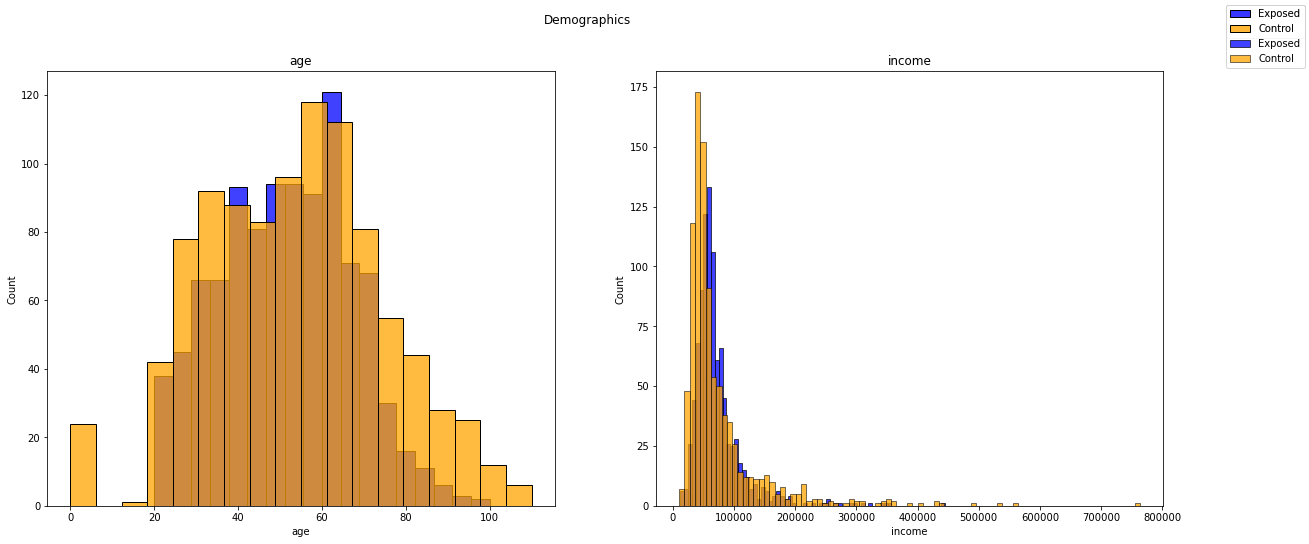

In [512]:
num = ['age', 'income']
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Demographics')

# Plot
for i in range(len(num)):
    axes[i].set_title(num[i])
    sns.histplot(exposed[num[i]], ax=axes[i], color="blue", label="Exposed")
    sns.histplot(control[num[i]], ax=axes[i], color="orange", label="Control")
    fig.legend()
    print(num[i])
    print("exposed_Mean: %f" % exposed[num[i]].mean())
    print("exposed_Median: %f" % exposed[num[i]].median())
    print("control_Mean: %f" % control[num[i]].mean())
    print("control_Median: %f" % control[num[i]].median())
    print()

Education

In [513]:
labs = {'edu100': 'Education_HighSchool', 
        'edu101': 'Education_SomeCollege', 
        'edu102': 'Education_CollegeGrad',
        'edu103': 'Education_MastersGrad'}
df = df.rename(columns = labs)
edu_list = [i for i in labs.values()]
education = df.groupby('exposed')[edu_list].sum()
education

,Education_HighSchool,Education_SomeCollege,Education_CollegeGrad,Education_MastersGrad
exposed,,,,
0,122,119,35,9
1,206,202,71,9


Gender

In [514]:
gender_list = ['gender_M', 'gender_F', 'gender_I']
gender = df.groupby('exposed')[gender_list].sum()
gender

,gender_M,gender_F,gender_I
exposed,,,
0,435,457,38
1,285,642,37


### Comparing means to find largest differences between the exposed and control group

In [515]:
def find_variables_with_largest_differences(dataset1, dataset2, num_top_variables=10):
    # Step 2: Calculate Differences
    differences = {}
    for column in dataset1.columns:
        if dataset1[column].nunique() == 2 and dataset2[column].nunique() == 2:
            proportion_dataset1 = dataset1[column].mean()
            proportion_dataset2 = dataset2[column].mean()
            absolute_difference = abs(proportion_dataset1 - proportion_dataset2)
            differences[column] = {
                'dataset1_mean': proportion_dataset1,
                'dataset2_mean': proportion_dataset2,
                'absolute_difference': absolute_difference
            }

    # Step 3: Sort and Select Top Variables
    sorted_differences = sorted(differences.items(), key=lambda x: x[1]['absolute_difference'], reverse=True)
    top_variables = [item[0] for item in sorted_differences[:num_top_variables]]
    top_variables_info = {item[0]: item[1] for item in sorted_differences[:num_top_variables]}

    return top_variables, top_variables_info

What are the top attributes that make the Treatment Group different from the Control group?

In [516]:
num_top_variables = 10
top_variables, top_variables_info = find_variables_with_largest_differences(df_control, df_exposed, num_top_variables)
data_dictionary['column_name'] = data_dictionary['column_name'].str.lower()

In [517]:
for variable in top_variables:
    print(variable)
    print(f"Attribute Name: {variable}")
    print(f"Control Mean: {top_variables_info[variable]['dataset1_mean']:.3f}")
    print(f"Exposed Mean: {top_variables_info[variable]['dataset2_mean']:.3f}")
    print(f"Absolute Difference: {top_variables_info[variable]['absolute_difference']:.3f}")
    print()

chr04
Attribute Name: chr04
Control Mean: 0.389
Exposed Mean: 0.720
Absolute Difference: 0.331

child0
Attribute Name: child0
Control Mean: 0.367
Exposed Mean: 0.083
Absolute Difference: 0.284

hobby_cooking
Attribute Name: hobby_cooking
Control Mean: 0.391
Exposed Mean: 0.657
Absolute Difference: 0.266

hobby_cooking_gourmet
Attribute Name: hobby_cooking_gourmet
Control Mean: 0.361
Exposed Mean: 0.619
Absolute Difference: 0.258

hobbyists
Attribute Name: hobbyists
Control Mean: 0.341
Exposed Mean: 0.583
Absolute Difference: 0.242

poc
Attribute Name: poc
Control Mean: 0.382
Exposed Mean: 0.624
Absolute Difference: 0.242

avid_readers
Attribute Name: avid_readers
Control Mean: 0.449
Exposed Mean: 0.689
Absolute Difference: 0.240

food
Attribute Name: food
Control Mean: 0.315
Exposed Mean: 0.549
Absolute Difference: 0.234

hobby_crafts
Attribute Name: hobby_crafts
Control Mean: 0.331
Exposed Mean: 0.563
Absolute Difference: 0.233

travel
Attribute Name: travel
Control Mean: 0.441
Expose

## Conducting factor analysis to reduce dimensions before clustering.

In [518]:
# Standardize all variables except dummy variables.
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df[non_dummy_columns]), columns=filtered_data.columns)

In [519]:
## Set the data to a matrix
TD = np.array(data_scaled)

In [520]:
pca = decomposition.PCA() ## create the function
XTrans = pca.fit_transform(data_scaled) ## apply PCA on data set
print(pca.explained_variance_ratio_) ## get the percent explained for each PC

[2.59171198e-01 7.04798039e-02 4.88084839e-02 4.59730786e-02
 3.60518191e-02 3.20865292e-02 2.72585751e-02 2.47265634e-02
 2.31722641e-02 2.06499553e-02 2.01744785e-02 1.86095636e-02
 1.83473443e-02 1.82158284e-02 1.76070019e-02 1.74067526e-02
 1.70246561e-02 1.69474952e-02 1.64808042e-02 1.53140635e-02
 1.49254836e-02 1.43970895e-02 1.40269662e-02 1.29384356e-02
 1.28586835e-02 1.27939628e-02 1.21497970e-02 1.17247590e-02
 1.10085772e-02 9.84473464e-03 9.08240677e-03 8.96918272e-03
 8.72915517e-03 8.39583085e-03 7.99993246e-03 7.67153537e-03
 7.19939132e-03 6.70650221e-03 6.09957344e-03 5.69137517e-03
 4.72719132e-03 4.26267067e-03 4.13243022e-03 3.87281073e-03
 3.35503256e-03 3.00114606e-03 2.15773820e-03 1.55823723e-03
 1.17187113e-03 1.06032610e-03 8.94278633e-04 7.09965331e-04
 5.43697803e-04 4.45841072e-04 2.46862648e-04 1.40266741e-04
 1.78382677e-33 1.78382677e-33 1.78382677e-33 1.78382677e-33
 1.78382677e-33 1.78382677e-33 1.78382677e-33 1.78382677e-33
 1.78382677e-33 1.783826

#### Examining the Explained Variance Ratio 

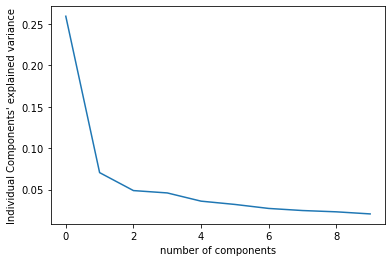

In [521]:
# Displaying the individual contribution of each component
plt.plot((pca.explained_variance_ratio_[0:10]))
plt.xlabel('number of components')
plt.ylabel("Individual Components' explained variance")
plt.show()

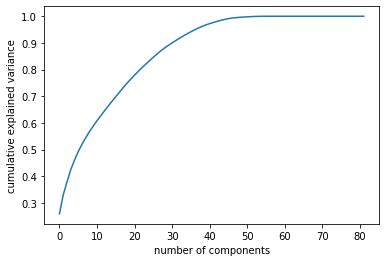

In [522]:
# Displaying the combined contribution of the components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [523]:
# choose the number of components you would like to include: 
numDimensions = 30
pct_of_data_explained = round(sum(pca.explained_variance_ratio_[0:numDimensions]),2)*100
print(f"Having {numDimensions} components will explain {pct_of_data_explained}% of the data") 

Having 30 components will explain 89.0% of the data


In [525]:
#Create New Dataframe
loadings = XTrans[:,:(29)]
loadings = pd.DataFrame(loadings)
#loadings.info()

We are looking to segment the Treatment and Control groups using their attributes. Using Cluster analysis:
- Recommend the appropriate number of clusters: 2 (treatment and control group).
- Explain the similarity measure you applied: I used the Ward criterion which aims to minimize the variance between points within the cluster.

I'll use the loadings from the factor analysis to do cluster analysis.

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.1605205535888672 seconds.
K=3 fitted in 0.3897082805633545 seconds.
K=4 fitted in 0.8955056667327881 seconds.
K=5 fitted in 1.0020580291748047 seconds.
K=6 fitted in 1.0002562999725342 seconds.
K=7 fitted in 1.9015443325042725 seconds.
K=8 fitted in 0.699803352355957 seconds.
K=9 fitted in 1.017493724822998 seconds.


<AxesSubplot:xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

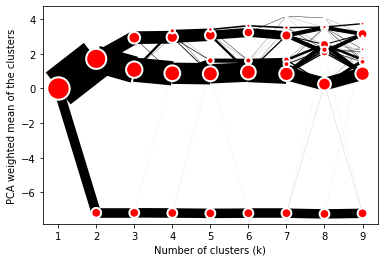

In [526]:
# this will show you the differences between clusters 
# and how much of the data is in each cluster
cgram = Clustergram(range(1, 10))
cgram.fit(loadings)
cgram.plot()

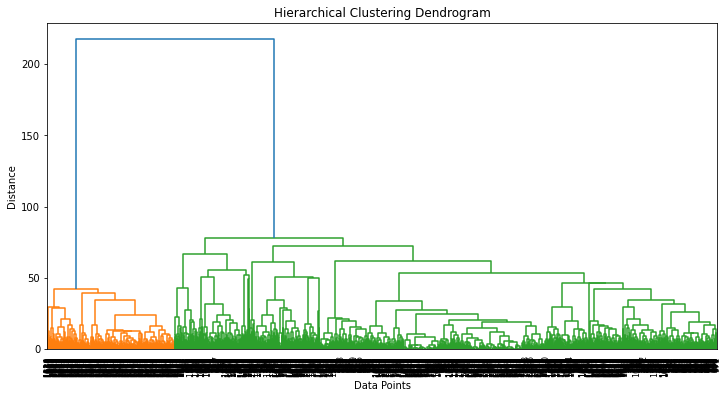

In [485]:
Z = linkage(loadings, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [486]:
def agglomerative_fn(data, n_clusters=2):
    model = AgglomerativeClustering(n_clusters = n_clusters).fit(data)
    
    return model

- Interpret, describe, and validate the cluster - The algorithm I used is based on the idea that points (people) are connected to other people with similar traits rather than people with dissimilar traits, so it starts by putting everybody in a separate cluster and then iteratively places similar people together until everyone is in 2 clusters. 

Unfortunately, the cluster evaluation scores below show that the clusters don't do a great job of labeling the treatment and control "cluster" that a person is in. I tried a couple of other clustering methods like K-means but also got bad scores-- this is probably just due to the nature of the data, although it would be possible if I had more time to try more data cleaning/transformation methods to improve the read.

In [487]:
def build_model(clustering_model, data, labels):
    
    model = clustering_model(data)

    print('homo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    print(50 * '-')
    
    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          %(metrics.homogeneity_score(labels, model.labels_),
            metrics.completeness_score(labels, model.labels_),
            metrics.v_measure_score(labels, model.labels_),
            metrics.adjusted_rand_score(labels, model.labels_),
            metrics.adjusted_mutual_info_score(labels,  model.labels_),
            metrics.silhouette_score(data, model.labels_)))

In [488]:
build_model(agglomerative_fn, loadings, labels)

homo	compl	v-meas	ARI	AMI	silhouette
--------------------------------------------------
0.228	0.324	0.268	0.155	0.267	0.328


# Part 2

In this part of the assignment you are free to use any statistical technique that can help you explain the outcome / response metric from the Treatment group compared to the Control group. You can use logistic regression, propensity score analysis and matching and/or any other technique. The response metric from the Treatment Group is an “Email SignUp”.

In [489]:
# Create Train and Test data 
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['exposed']),df['exposed'],test_size=0.25,random_state=0) 
X_train.shape, X_test.shape, y_train.shape, y_test.shape,y_train.sum(),y_test.sum()
X_train_sample = X_train
X_test_sample = X_test

y_train_sample = y_train
y_test_sample = y_test

In [490]:
############# LogReg
LRclf = LogisticRegression(solver = 'newton-cg', class_weight = 'auto')
LRclf.fit(X_train_sample, y_train_sample)

LogisticRegression(class_weight='auto', solver='newton-cg')

In [495]:
lr_features = LRclf.coef_[0]
cols = X_train.columns.values

In [498]:
# Create a dataframe with features
features_dataframe = pd.DataFrame( {'LR feature importances': lr_features})
features_dataframe.set_index(cols, drop=True, inplace=True, verify_integrity = True)
fet_vars = [var for var in features_dataframe.columns ]

# create scaler
scaler = MinMaxScaler(feature_range=(1, 100))
#  fit  the scaler to the train set
scaler.fit(features_dataframe[fet_vars]) 
# transform the train and test set
features_dataframe[fet_vars] = scaler.transform(features_dataframe[fet_vars])

What are the variables explaining the differences between the Treatment and the Control group?
- Treatment Group is more likely to have Lowest Average credit card balance= True (CHC13).
- Treatment Group is more likely to be in lower numbered Congressional Districts (~1-10).
- Treatment Group is more likely to be Female.
- Treatment Group is more likely to be High School education level.
- Treatment Group is more likely to like walking.
- Treatment group is more likely to own a cat.
- Treatment group is more likely to purchase home furnishings.


<BarContainer object of 37 artists>

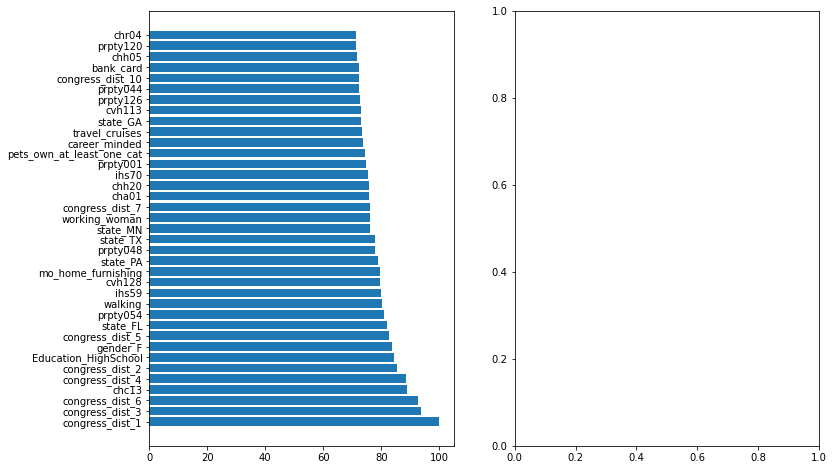

In [499]:
features_dataframe.T.mean().sort_values(ascending=False)[:37].to_csv('key_features_email_signup.csv')
key_features = features_dataframe.T.mean().sort_values(ascending=False)[:37]
key_features=key_features.drop(index=[])
features_dataframe = features_dataframe.T[key_features.index]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(features_dataframe.columns, features_dataframe.mean())

Did you train your model? Explain - Yes, I trained the logistic regression model to improve classification.

In [500]:
predtrn=LRclf.predict_proba(X_train)[:,1]
y_test_predict=LRclf.predict_proba(X_test)[:,1]
features_dataframe.T.mean().sort_values(ascending=False)[:25]
y_train_pred = np.where(predtrn >= 0.006, 1, 0)
y_test_pred = np.where(y_test_predict >= 0.006, 1, 0)
cm_train = confusion_matrix(y_train_sample, y_train_pred)
cm_test = confusion_matrix(y_test_sample, y_test_pred)

In [501]:
# AUC Score
roc_auc_score(y_test_sample, y_test_predict),roc_auc_score(y_train_sample, predtrn)

(0.991408875780232, 1.0)

In [502]:
print(cm_train)
print(cm_test)
print('Train Accuracy' + str(accuracy_score(y_train, y_train_pred)))
print('Test Accuracy' + str(accuracy_score(y_test, y_test_pred)))

[[501 208]
 [  0 739]]
[[166  78]
 [  1 238]]
Train Accuracy0.856353591160221
Test Accuracy0.8364389233954451


<i> Did you get inconclusive results? Was the quality of the data a factor in the inconclusive results? Explain potential reasons the results of your model are inconclusive and/or statistically significant? </i>

I received statistically significant results. However, there were data issues that limited the reliability of the modeling results. For example, I was modeling off of the raw data which had a lot of multicollinearity and a lot of missing values. 